https://www.kaggle.com/sshikamaru/car-object-detection

https://machinelearningmastery.com/how-to-perform-object-detection-with-yolov3-in-keras/

# Configurations

## Import Libraries

In [16]:
import os
from google.colab import drive
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from urllib import request
import numpy as np
import sys

# Image Preprocessing
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
#import onnx2keras
#import onnx

## Download Dataset From Kaggle

In [17]:
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [18]:
%cd /content/drive/My Drive/Colab Notebooks/Machine Learning Projects/(Kaggle) Car Object Detection/Dataset

/content/drive/My Drive/Colab Notebooks/Machine Learning Projects/(Kaggle) Car Object Detection/Dataset


In [19]:
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/My Drive/Colab Notebooks/Machine Learning Projects/(Kaggle) API Token"

In [20]:
#!kaggle datasets download -d sshikamaru/car-object-detection

## Setup Weights & Biases

WandB is a central dashboard to keep track of your hyperparameters, system metrics, and predictions so you can compare models live

In [21]:
#!wandb login

In [22]:
#import wandb
#from wandb.keras import WandbCallback

#wandb.init(project='Car Object Detection', entity='lucaslokchan')

# Exploratory Data Analysis

## Loading Data

In [23]:
training_image_path = 'data/training_images/'
testing_image_path = 'data/testing_images/'

In [24]:
label = pd.read_csv('data/train_solution_bounding_boxes.csv')
label.head()

,image,xmin,ymin,xmax,ymax
0,vid_4_1000.jpg,281.259045,187.035071,327.727931,223.225547
1,vid_4_10000.jpg,15.163531,187.035071,120.329957,236.430180
2,vid_4_10040.jpg,239.192475,176.764800,361.968162,236.430180
3,vid_4_10020.jpg,496.483358,172.363256,630.020261,231.539575
4,vid_4_10060.jpg,16.630970,186.546010,132.558611,238.386422


In [25]:
print('Number of cars (bounding box) in the dataset:',len(label))

Number of cars (bounding box) in the dataset: 559


In [26]:
print('Training Image:', len(os.listdir(training_image_path)))
print('Testing Image:', len(os.listdir(testing_image_path)))

Training Image: 1001
Testing Image: 175


In [27]:
print('Shape of each image:', plt.imread(training_image_path + 'vid_4_1000.jpg').shape)

Shape of each image: (380, 676, 3)


In [28]:
def plot(img_num):
  image = sorted(os.listdir(training_image_path))[img_num]
  plot = plt.imread(training_image_path + image)

  bbox = label[label['image'] == image]

  fig, ax = plt.subplots(figsize=(8, 5))

  for i in range(len(bbox)):
    xmin = bbox.iloc[i]['xmin']
    ymin = bbox.iloc[i]['ymin']
    xmax = bbox.iloc[i]['xmax']
    ymax = bbox.iloc[i]['ymax']
    width = xmax - xmin
    height = ymax - ymin
    rect = Rectangle([xmin, ymin], width, height, color='r', fill=False)
    plt.gca().add_patch(rect)

  ax.imshow(plot)
  ax.set_xticks([])
  ax.set_yticks([])
  plt.show()

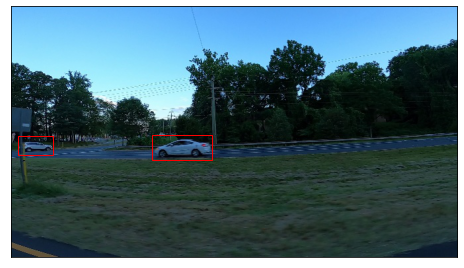

In [29]:
plot(950)

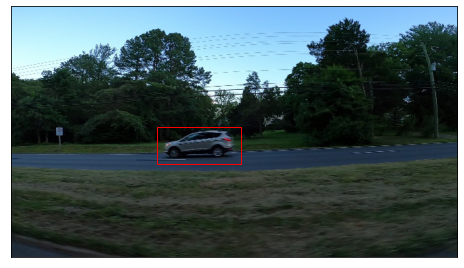

In [30]:
plot(1000)

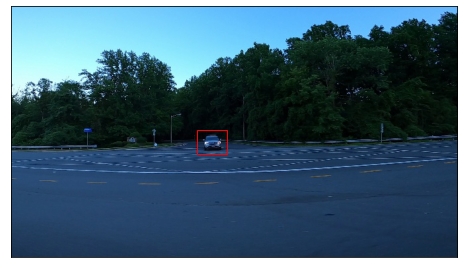

In [31]:
plot(0)

# Image Preprocessing


Keras provides the [img_to_array()](https://machinelearningmastery.com/how-to-load-convert-and-save-images-with-the-keras-api/#:~:text=Keras%20provides%20the%20img_to_array(),use%20with%20deep%20learning%20models.&text=This%20can%20be%20useful%20if,then%20be%20saved%20or%20viewed.) function for converting a loaded image in PIL format into a NumPy array for use with deep learning models

We will first load the image, sample it into 416x416 since the input size of Yolov3 is such. We than convert the image to into a Numpy array and scale pixel values to [0, 1] by dividing the array by 255

In [32]:
img = load_img(training_image_path + 'vid_4_9060.jpg', target_size=(416, 416))
img = img_to_array(img)
img /= 255.0
img = np.expand_dims(img, 0)

In [33]:
image = load_img(training_image_path + 'vid_4_9060.jpg')
image = img_to_array(image)

# Yolov3

Download yolov3 pretrained weights and python script 'yolo3_one_file_to_detect_them_all.py' from keras-yolov3 [Github](https://github.com/experiencor/keras-yolo3) repo

We will use this script to make yolov3 model, read and load weights into the model and save the model in HDF5 format

In [34]:
def download_yolov3():
  weight = 'https://pjreddie.com/media/files/yolov3.weights'
  script = 'https://raw.githubusercontent.com/experiencor/keras-yolo3/768c524f277adbfd26c2f44d73cb1826bbaf2d10/yolo3_one_file_to_detect_them_all.py'
  request.urlretrieve(weight, 'yolov3.weights')
  #request.urlretrieve(script, 'yolo3_one_file_to_detect_them_all.py')

#download_yolov3()

In [35]:
import yolo3_one_file_to_detect_them_all as yolov3

In [36]:
%%capture
model = yolov3.make_yolov3_model()
weight_reader = yolov3.WeightReader('yolov3.weights')
weight_reader.load_weights(model)
model.save('model.h5')

In [37]:
model = keras.models.load_model('model.h5')

Now we have successfully loaded yolov3 into keras

In [38]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv_0 (Conv2D)                (None, None, None,   864         ['input_1[0][0]']                
                                32)                                                               
                                                                                                  
 bnorm_0 (BatchNormalization)   (None, None, None,   128         ['conv_0[0][0]']                 
                                32)                                                           

# Predict

In [40]:
prediction = model.predict(img)

In [48]:
[a.shape for a in prediction]

[(1, 13, 13, 255), (1, 26, 26, 255), (1, 52, 52, 255)]

In [63]:
# define the anchors
anchors = [[116,90, 156,198, 373,326], [30,61, 62,45, 59,119], [10,13, 16,30, 33,23]]
input_h = 380
input_w = 676
image_h = 380
image_w = 676
# define the probability threshold for detected objects
class_threshold = 0.6
boxes = list()
for i in range(len(prediction)):
    # decode the output of the network
    boxes += yolov3.decode_netout(prediction[i][0], anchors[i], class_threshold, input_h, input_w, 1)

labels = ['car']
yolov3.correct_yolo_boxes(boxes, image_h, image_w, input_h, input_w)

In [57]:
image.shape

(380, 676, 3)